# Soybean Wilting Classification using a CNN

In [1]:
import cv2 as cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(precision=4)

# Get reproducible results
random_state = 46
np.random.seed(random_state)
tf.random.set_seed(random_state)

Using TensorFlow backend.


## GPU configuration
If you have a GPU, enable experimental memory growth.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## File Paths

In [10]:
train_dir = "data/TrainData-C2/"
train_ann = "data/TrainData-C2/TrainAnnotations.csv"

train_dir_patches = "data/TrainData-C2_patches_wo_extra/"
train_ann_patches = "data/TrainData-C2_patches_wo_extra/TrainAnnotations.csv"

test_dir = "data/TestData-C2/"
test_patches_dir = "data/TestData-C2_patches/"

##  Define functions for image patches

In [4]:
import cv2
import sys
import os
from os import listdir
from os.path import isfile, join


print("Reading annotations...")
train_ann_df = pd.read_csv(train_ann, dtype={'file_name': 'object', 'annotation': 'category'})

rows = 5
columns = 5


def generate_image_patches(img, rows, cols):
    patches = []
    sizeX = img.shape[1]
    sizeY = img.shape[0]

    for i in range(0,rows):
        for j in range(0, cols):
            center = (112 + (sizeX - 224)/(rows - 1)*i, 112+(sizeY - 224)/(cols-1)*j)
            patches.append(cv2.getRectSubPix(img, (224, 224), center))
            
    return patches
    
                    
def is_image(file):
    return any(map(lambda x: file.endswith(x), ['jpg', 'jpeg', 'png']))


def generate_patches(in_dir, out_dir, rows, cols):
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    images = [f for f in listdir(in_dir) if isfile(join(in_dir, f)) and is_image(f)]   
    for im in images:
        print(im)
        img = cv2.imread(join(in_dir, im))
        patches = generate_image_patches(img, rows, cols)
        
        for i in range(0,rows):
            for j in range(0, cols):
                patch = patches[i*rows + j]
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                cv2.imwrite(out_dir + '/' + patch_name, patch)


def generate_patch_annotations(in_dir, ann_df, rows, cols):
    """
    TODO Avoid the disk IO and traverse the dataframe instead
    """
    images = [f for f in listdir(in_dir) if isfile(join(in_dir, f)) and is_image(f)]
    patches_ann = {}
    
    for im in images:
        for i in range(0,rows):
            for j in range(0, cols):
                patch_name = im.split('.')[0] + '_' + str(i) + '_' + str(j) + '.png'
                patches_ann[patch_name] = ann_df[ann_df['file_name'] == im].values[0][1]
    
    patches_ann_df = pd.DataFrame.from_dict(patches_ann, orient='index', columns=['annotation'])
    return patches_ann_df
    

Reading annotations...


## Create 224x224 patches

In [34]:


generate_patches(train_dir, train_dir_patches, rows, columns)
train_patches_ann_df = generate_patch_annotations(train_dir, train_ann_df, rows, columns)
train_patches_ann_df.to_csv(train_ann_patches, index_label='file_name',columns=['annotation'])

025666.jpg
016356.jpg
014258.jpg
023471.jpg
020941.jpg
014783.jpg
022349.jpg
022291.jpg
002575.jpg
016756.jpg
008227.jpg
004653.jpg
011305.jpg
008497.jpg
003104.jpg
001133.jpg
028135.jpg
015363.jpg
010711.jpg
005953.jpg
016139.jpg
003173.jpg
009112.jpg
014429.jpg
016763.jpg
007524.jpg
004736.jpg
005305.jpg
007498.jpg
008354.jpg
004039.jpg
024891.jpg
013632.jpg
005633.jpg
013992.jpg
014267.jpg
007963.jpg
013848.jpg
005789.jpg
018732.jpg
022895.jpg
026079.jpg
027152.jpg
023403.jpg
018021.jpg
008208.jpg
023019.jpg
009963.jpg
012280.jpg
017749.jpg
017955.jpg
000934.jpg
008333.jpg
018884.jpg
003124.jpg
006399.jpg
007273.jpg
008483.jpg
008108.jpg
015133.jpg
010216.jpg
027106.jpg
000758.jpg
008882.jpg
019171.jpg
014379.jpg
019053.jpg
013386.jpg
000747.jpg
012521.jpg
010641.jpg
014138.jpg
013249.jpg
002324.jpg
011612.jpg
007314.jpg
004067.jpg
013195.jpg
007857.jpg
013936.jpg
012855.jpg
020927.jpg
009020.jpg
003571.jpg
004043.jpg
022870.jpg
020018.jpg
011755.jpg
023634.jpg
028114.jpg
029948.jpg

001064.jpg
001326.jpg
015922.jpg
003621.jpg
008218.jpg
004365.jpg
012263.jpg
009445.jpg
003916.jpg
014312.jpg
018274.jpg
017969.jpg
016652.jpg
008724.jpg
017928.jpg
000770.jpg
003971.jpg
000957.jpg
020140.jpg
009613.jpg
007388.jpg
014421.jpg
025523.jpg
028078.jpg
003530.jpg
021863.jpg
006977.jpg
009135.jpg
012148.jpg
005592.jpg
007990.jpg
016331.jpg
027294.jpg
015837.jpg
000917.jpg
003956.jpg
004153.jpg
027771.jpg
008689.jpg
003496.jpg
015368.jpg
009758.jpg
012266.jpg
008990.jpg
005873.jpg
011853.jpg
029624.jpg
022415.jpg
027271.jpg
005419.jpg
018860.jpg
017213.jpg
009213.jpg
013868.jpg
017631.jpg
006213.jpg
013254.jpg
029049.jpg
000876.jpg
018968.jpg
027187.jpg
018616.jpg
001197.jpg
018937.jpg
014822.jpg
003964.jpg
024334.jpg
001506.jpg
010172.jpg
001636.jpg
004343.jpg
018945.jpg
019190.jpg
009870.jpg
002888.jpg
027681.jpg
015529.jpg
018416.jpg
001861.jpg
005904.jpg
026794.jpg
004458.jpg
012160.jpg
016196.jpg
018316.jpg
014643.jpg
015751.jpg
008705.jpg
010717.jpg
001621.jpg
029384.jpg

## Train model

In [11]:
def get_compiled_model():
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg_model.trainable = False
        
    # for layer in vgg_model.layers[:15]:
    #    print("Making vgg model layer {} not trainable".format(layer))
    #    layer.trainable = False

    # for layer in vgg_model.layers[15:]:
    #    print("Making vgg model layer {} trainable".format(layer))
    #    layer.trainable = True

    model = tf.keras.models.Sequential([
        vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(5)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

Computing class weights...
Splitting data into training and validation sets...
Defining data generators...
Defining train data generator...
Found 24968 validated image filenames belonging to 5 classes.
Defining validation data generator...
Found 4407 validated image filenames belonging to 5 classes.
Defining model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
d

780/780 [==============================] - 214s 275ms/step - loss: 0.3547 - accuracy: 0.8493 - val_loss: 0.3706 - val_accuracy: 0.8479
Epoch 45/60
780/780 [==============================] - 209s 268ms/step - loss: 0.3486 - accuracy: 0.8507 - val_loss: 0.4057 - val_accuracy: 0.8305
Epoch 46/60
780/780 [==============================] - 213s 274ms/step - loss: 0.3424 - accuracy: 0.8526 - val_loss: 0.3535 - val_accuracy: 0.8506
Epoch 47/60
780/780 [==============================] - 210s 270ms/step - loss: 0.3385 - accuracy: 0.8519 - val_loss: 0.3725 - val_accuracy: 0.8307
Epoch 48/60
780/780 [==============================] - 209s 269ms/step - loss: 0.3396 - accuracy: 0.8539 - val_loss: 0.3949 - val_accuracy: 0.8549
Epoch 49/60
780/780 [==============================] - 210s 269ms/step - loss: 0.3457 - accuracy: 0.8522 - val_loss: 0.3504 - val_accuracy: 0.8513
Epoch 50/60
780/780 [==============================] - 211s 271ms/step - loss: 0.3286 - accuracy: 0.8562 - val_loss: 0.3827 - val_

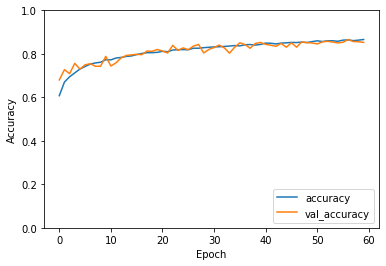

In [14]:
def compute_class_weights(df, y_col):
    """
    Returns a dictionary mapping class labels to 'balanced' weights based on the
    frequency of the weights across the labels in the specified dataframe
    """
    y = df[[y_col]].to_numpy().flatten()
    weights = class_weight.compute_class_weight('balanced', np.unique(y), y)
    return {label: weight for label, weight in enumerate(weights)}
    
#print("Reading annotations...")
ann_df = pd.read_csv(train_ann_patches, dtype={'file_name': 'object', 'annotation': 'category'})

print("Computing class weights...")
class_weights = compute_class_weights(ann_df, 'annotation')

print("Splitting data into training and validation sets...")
train_df, val_df = train_test_split(ann_df,
                                    train_size=0.85,
                                    random_state=138,
                                    shuffle=True,
                                    stratify=ann_df[['annotation']].to_numpy().flatten())

print("Defining data generators...")
data_gen_args = dict(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
    # preprocessing_function=lambda x: cv2.getRectSubPix(x, (224,224), (200, 200))
)
train_datagen = ImageDataGenerator(**data_gen_args)
val_datagen = ImageDataGenerator(**data_gen_args)


print("Defining train data generator...")
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=train_dir_patches,
        x_col="file_name",
        y_col="annotation",
        batch_size=32,
        class_mode='sparse',
        target_size=(224,224)
)
print("Defining validation data generator...")
val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=train_dir_patches,
        x_col="file_name",
        y_col="annotation",
        batch_size=32,
        class_mode='sparse',
        target_size=(224,224)
)

# Model
print("Defining model...")
model = get_compiled_model()
model.summary()

#model.load_weights('model_vgg16.h5')

print('Fitting model...')
history = model.fit(train_generator, 
                    steps_per_epoch=int(24968 / 32), 
                    epochs=60, 
                    validation_data=val_generator, 
                    class_weight=class_weights, 
                    verbose=1, 
                    validation_steps=int(4407 / 32))

print('Evaluating model...')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_result = model.evaluate(val_generator, verbose=1)
print('Test result:', test_result)

# Save the model weights
model.save_weights('model_vgg16_c2_wo_extra.h5')



## Generate predictions on test dataset

### Generate image patches for test dataset
These will be generated to the file systems, so it's only necessary to run this once.

In [12]:
# An extra subdirectory for the patches is necessary due to a
# quirk in Keras flow_from_directory where even though class_mode=None,
# images are still required to be loaded from a subdirectory.
# 
# See https://github.com/keras-team/keras/issues/3946 for more details.
generate_patches(test_dir, test_patches_dir + "/test", rows, columns)


016356.jpg
014783.jpg
014267.jpg
013848.jpg
018884.jpg
015133.jpg
019171.jpg
019053.jpg
013936.jpg
011755.jpg
029684.jpg
013751.jpg
017385.jpg
015554.jpg
029696.jpg
016688.jpg
018778.jpg
014761.jpg
014625.jpg
027511.jpg
027435.jpg
018624.jpg
016258.jpg
028816.jpg
026412.jpg
018825.jpg
014047.jpg
018698.jpg
015993.jpg
018089.jpg
013123.jpg
016007.jpg
015637.jpg
018531.jpg
029290.jpg
012803.jpg
018892.jpg
018807.jpg
018964.jpg
018147.jpg
018689.jpg
018641.jpg
014091.jpg
018963.jpg
018988.jpg
026945.jpg
014723.jpg
015291.jpg
026692.jpg
015867.jpg
015952.jpg
012970.jpg
018590.jpg
019017.jpg
029162.jpg
028515.jpg
015011.jpg
018681.jpg
027876.jpg
018723.jpg
014493.jpg
012394.jpg
018876.jpg
015092.jpg
027958.jpg
013490.jpg
014527.jpg
028078.jpg
017213.jpg
018937.jpg
018945.jpg
018416.jpg
018316.jpg
015620.jpg
015771.jpg
014813.jpg
014943.jpg
029341.jpg
017224.jpg
017024.jpg
014238.jpg
013563.jpg
017405.jpg
014228.jpg
019026.jpg
012529.jpg
027409.jpg
013803.jpg
011749.jpg
029441.jpg
016116.jpg

In [15]:
import os
import csv
    
from scipy import stats
from collections import Counter

model = get_compiled_model()
model.load_weights('model_vgg16_c2_wo_extra.h5')

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    samplewise_center=True,
    samplewise_std_normalization=True
)

test_generator = test_datagen.flow_from_directory(
    directory=test_patches_dir,
    target_size=(224,224),
    class_mode=None,
    shuffle=False
)

y_hat_test_logits = pred = model.predict(test_generator)
y_hat_test = tf.map_fn(lambda x: tf.argmax(x), y_hat_test_logits, dtype=tf.int64)

y_hat_patch_groups = np.split(y_hat_test, len(y_hat_test)/(rows * columns))
y_hat_whole_images = list(map(lambda x: stats.mode(x).mode[0], y_hat_patch_groups))

for k, v in sorted(Counter(y_hat_whole_images).items()): 
    print(str(k) + ': '+ str(v))    
    
one_hots = [np.zeros((5,1)) for pred in y_hat_whole_images]
for i in range(len(one_hots)):
    pred = y_hat_whole_images[i]  # the index of the one-hot encoding
    one_hots[i][pred] = 1
with open('cnn_predictions_c2_extra.csv', 'w') as predictions_file:
    writer = csv.writer(predictions_file)
    for pred in one_hots:
        pred = np.array(pred, dtype=int)
        writer.writerow(pred.T.tolist()[0])
        
print('Done.')


Found 2500 images belonging to 1 classes.
0: 24
1: 20
2: 14
3: 26
4: 16
Done.


In [13]:
del model
K.clear_session()